# Polyssifier

In [2]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix

from polyssifier import poly

In [2]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,101309,29,True,NotTwin,,52385_82248,52385,82248,NaN,Black or African Am.,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,White,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,White,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,White,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [3]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,30,True,NotTwin,,56077_85897,56077,85897,NaN,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
566,670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
567,671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
568,672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [4]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [4]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(4, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [12]:
def run(df_boot, data, seed):
#     df_bootstrap = pd.DataFrame()
#     for j in range(0, len(df_boot)):
#         index = random.randint(0, len(df_boot)-1)
#         frames = [df_bootstrap, df_boot[index:index+1]]
#         df_bootstrap = pd.concat(frames)

#     df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148) # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))
    

    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = poly(x_correl, y_sex, n_folds=10)

    return coef

In [7]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [8]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        
        


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████████████████████████████████████████████████| 570/570 [01:51<00:00,  5.12it/s]


In [13]:
run_polyssifier = run(df_boot, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 438992.52it/s]
2023-03-23 15:59:05,072 - polyssifier - INFO - Detected 2 classes in label
2023-03-23 15:59:05,073 - polyssifier - INFO - Building classifiers ...
2023-03-23 15:59:05,078 - polyssifier - INFO - Initialization, done.
2023-03-23 15:59:05,122 - polyssifier - INFO - Training Multilayer Perceptron 0
2023-03-23 15:59:08,942 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.84, 3.82 sec
2023-03-23 15:59:08,971 - polyssifier - INFO - Training Multilayer Perceptron 1
2023-03-23 15:59:13,107 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.84, 4.14 sec
2023-03-23 15:59:13,115 - polyssifier - INFO - Training Multilayer Perceptron 2
2023-03-23 15:59:15,831 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.93, 2.72 sec
2023-03-23 15:59:15,839 - polyssifier - INFO - Training Multilayer Perceptron 3
2023-03-23 15:5

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

predict proba return shape (57,)


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2023-03-23 16:03:05,374 - polyssifier - INFO - Linear SVM                 9: Train 1.00/Test 0.80, 14.53 sec
2023-03-23 16:03:05,381 - polyssifier - INFO - Training Decision Tree 0

predict proba return shape (57,)


2023-03-23 16:03:05,576 - polyssifier - INFO - Decision Tree              4: Train 1.00/Test 0.57, 0.03 sec
2023-03-23 16:03:05,583 - polyssifier - INFO - Training Decision Tree 5
2023-03-23 16:03:05,611 - polyssifier - INFO - Decision Tree              5: Train 1.00/Test 0.60, 0.03 sec
2023-03-23 16:03:05,617 - polyssifier - INFO - Training Decision Tree 6
2023-03-23 16:03:05,644 - polyssifier - INFO - Decision Tree              6: Train 1.00/Test 0.60, 0.03 sec
2023-03-23 16:03:05,652 - polyssifier - INFO - Training Decision Tree 7
2023-03-23 16:03:05,678 - polyssifier - INFO - Decision Tree              7: Train 1.00/Test 0.50, 0.03 sec
2023-03-23 16:03:05,686 - polyssifier - INFO - Training Decision Tree 8
2023-03-23 16:03:05,712 - polyssifier - INFO - Decision Tree              8: Train 1.00/Test 0.50, 0.03 sec
2023-03-23 16:03:05,719 - polyssifier - INFO - Training Decision Tree 9
2023-03-23 16:03:05,746 - polyssifier - INFO - Decision Tree              9: Train 1.00/Test 0.70, 0

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.839575  0.065562  0.725806  0.927160
Nearest Neighbors     train  0.783555  0.014280  0.767471  0.813230
                      test   0.685937  0.073642  0.581266  0.774194
SVM                   train  0.996036  0.000604  0.995184  0.996944
                      test   0.829071  0.070418  0.724566  0.906948
Linear SVM            train  0.999951  0.000080  0.999801  1.000000
                      test   0.835851  0.048439  0.761787  0.909877
Decision Tree         train  1.000000  0.000000  1.000000  1.000000
                      test   0.590044  0.074759  0.495037  0.705556
Random Forest         train  0.999963  0.000058  0.999824  1.000000
                      test   0.672880  0.080720  0.514815  0.772222
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.856659  0.045821 

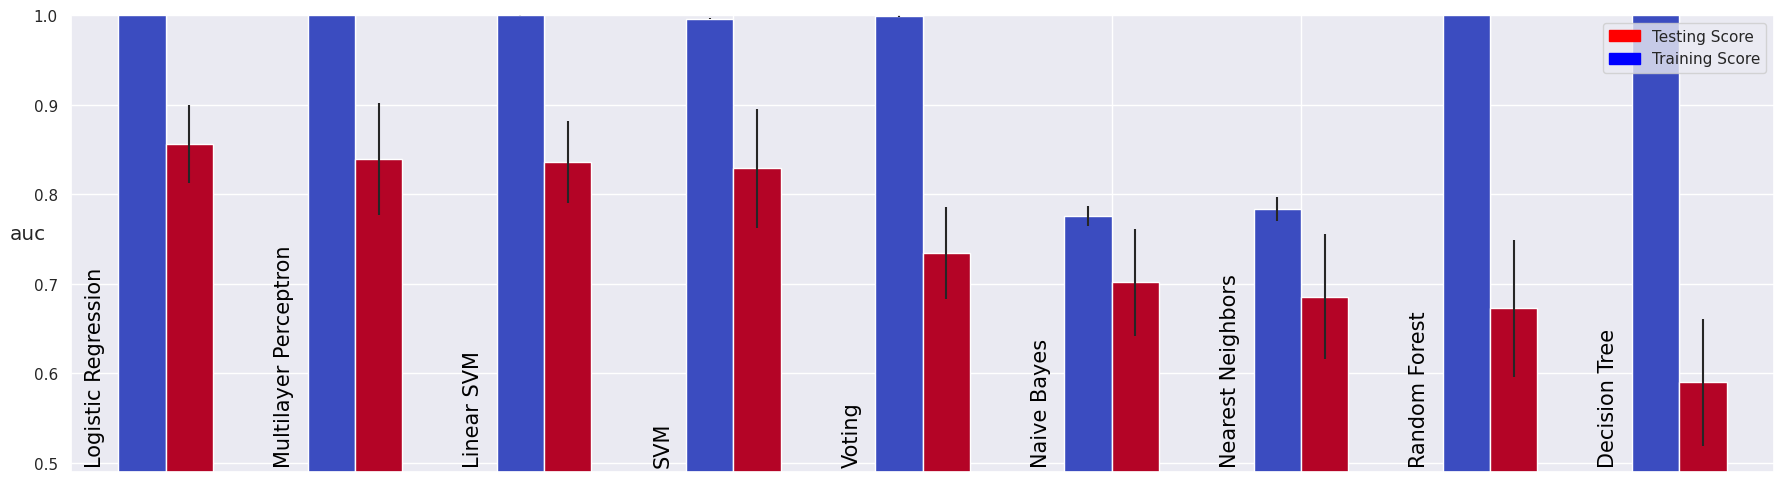

In [14]:
run_polyssifier.plot_scores()

2023-03-23 16:11:21,657 - Report - INFO - Plotting Linear SVM coefs to temp_Linear SVM_feature_ranking.png


Linear SVM


2023-03-23 16:11:21,965 - Report - INFO - Plotting Decision Tree coefs to temp_Decision Tree_feature_ranking.png


Decision Tree


2023-03-23 16:11:22,258 - Report - INFO - Plotting Random Forest coefs to temp_Random Forest_feature_ranking.png


Random Forest


2023-03-23 16:11:22,580 - Report - INFO - Plotting Logistic Regression coefs to temp_Logistic Regression_feature_ranking.png


Logistic Regression


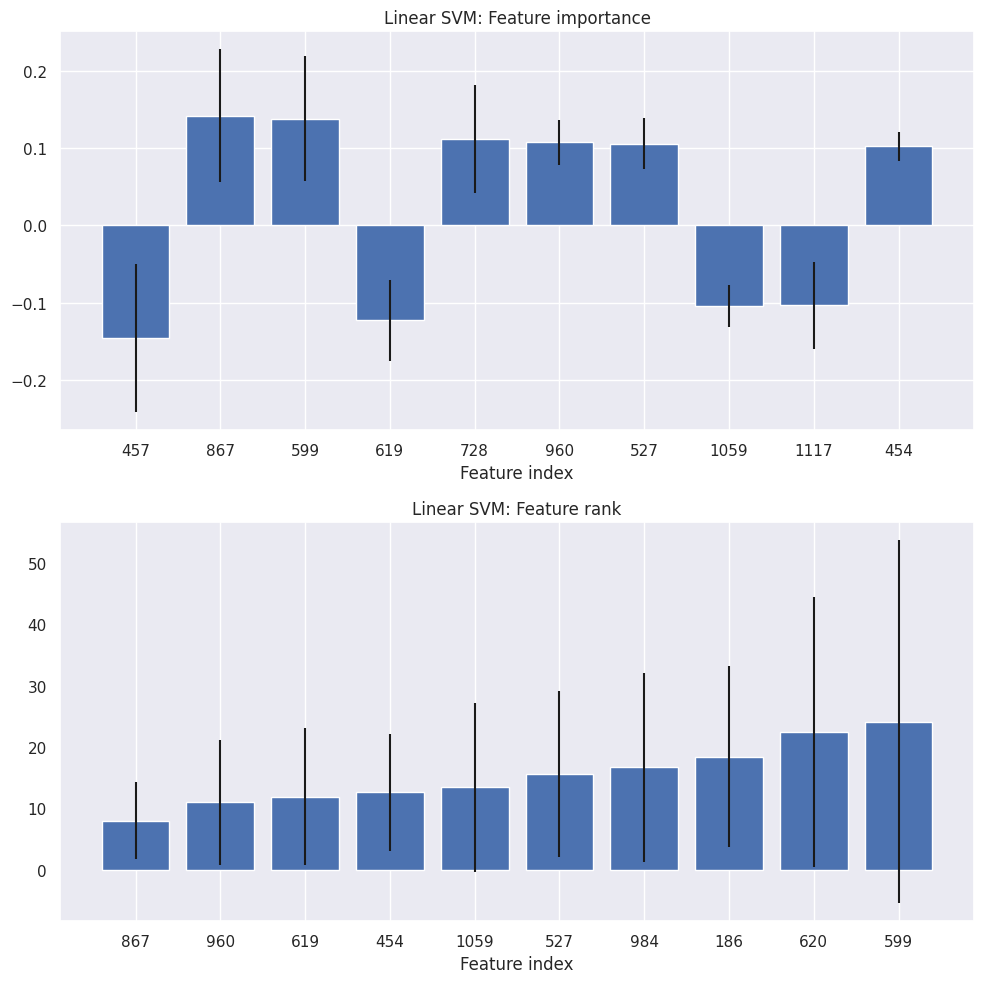

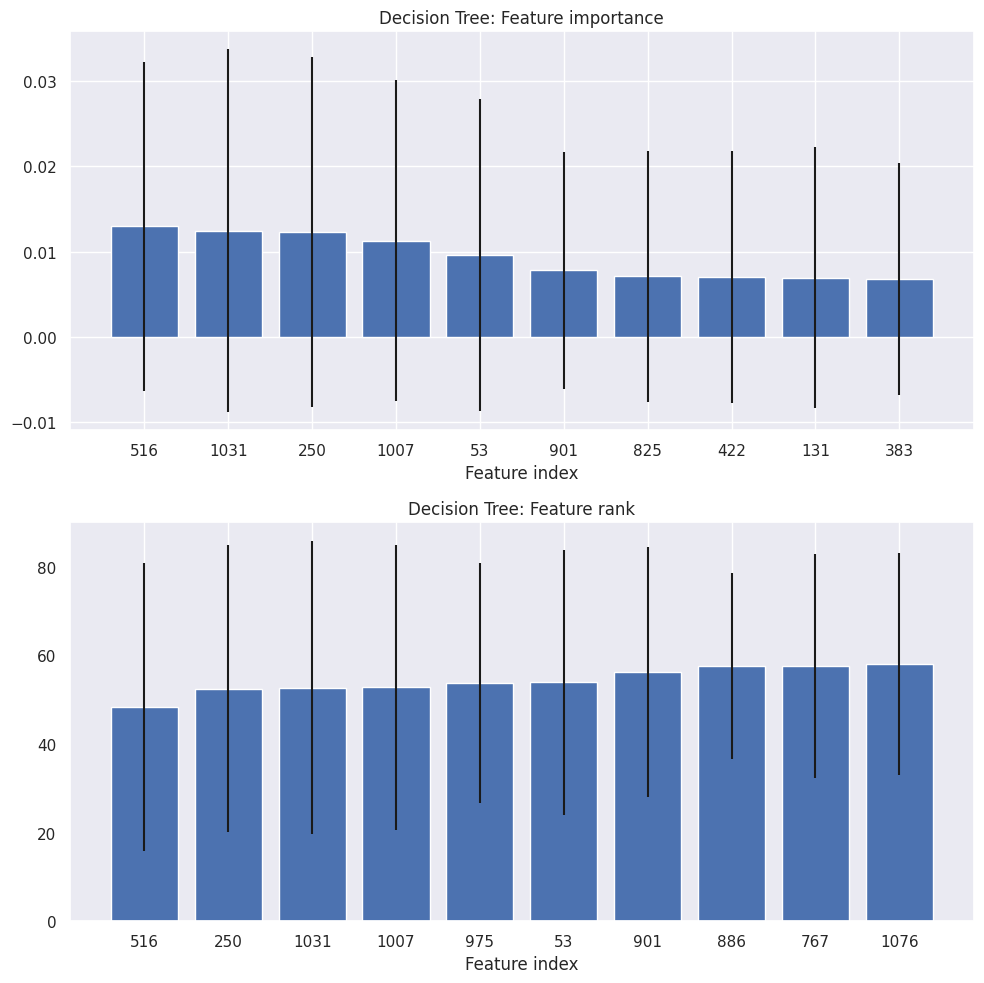

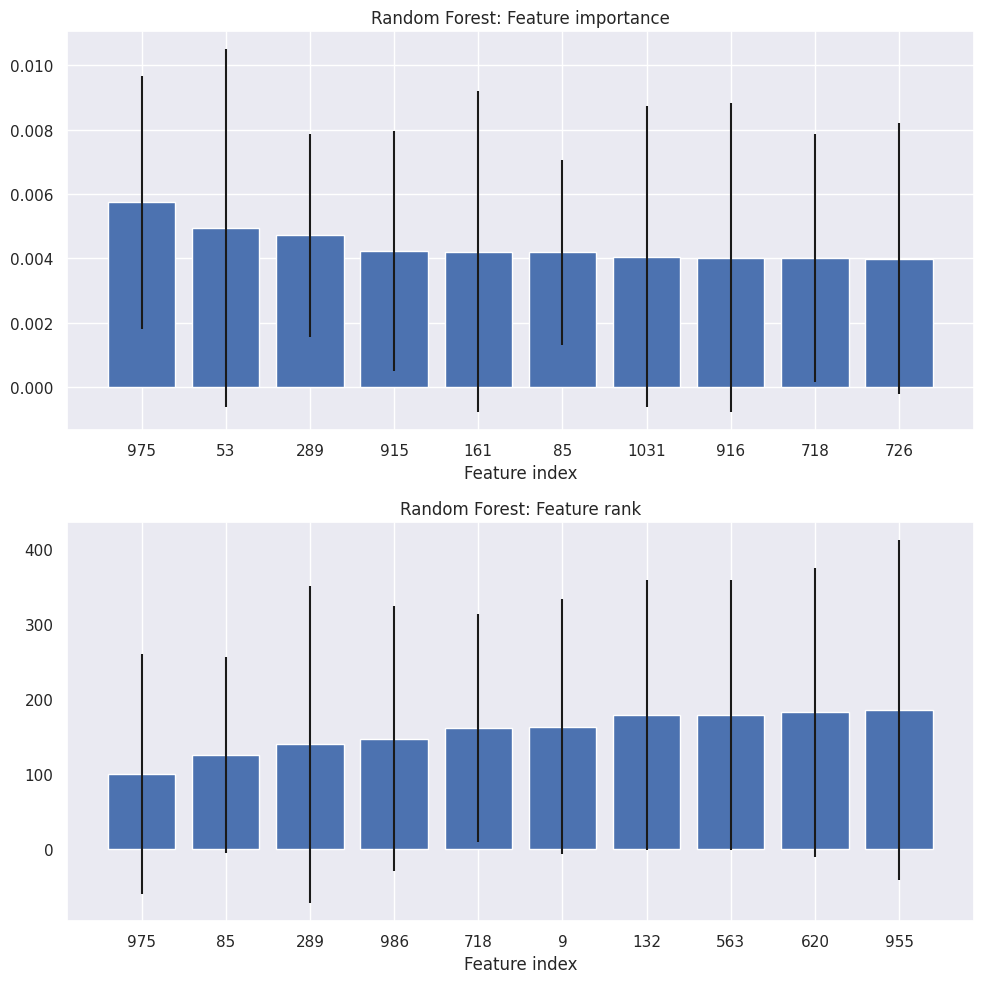

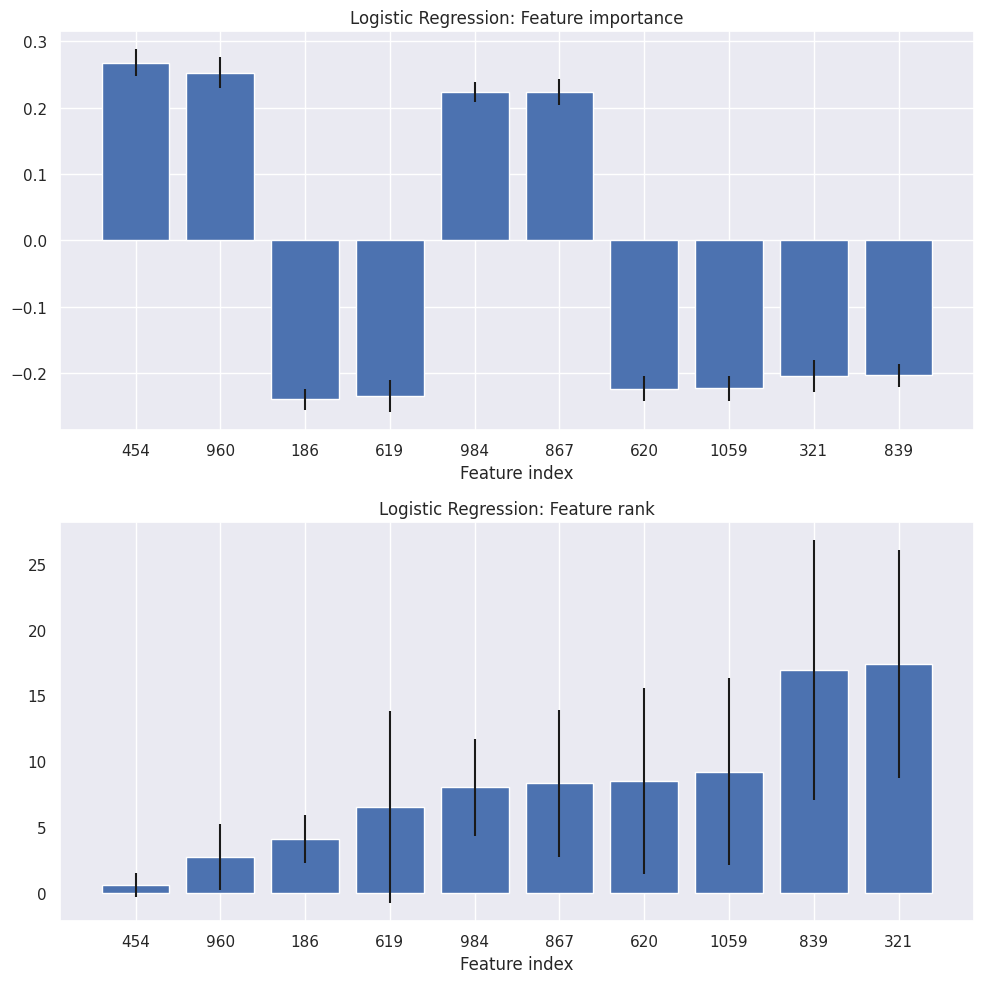

In [15]:
run_polyssifier.plot_features(ntop=10)

# Logistic model regression

In [5]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [02:17<00:00,  4.15it/s]


In [15]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [16]:
def run(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl

In [17]:
run_logistic = run(df_boot, data, SEEDS)

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 340757.31it/s]

train: 456 test: 114


[array([0.93478261, 0.7826087 , 0.82608696, 0.73913043, 0.7173913 ,
       0.65217391, 0.8       , 0.77777778, 0.77777778, 0.71111111])]
predicted class  Femme  Homme
actual class                 
Femme               41     20
Homme               14     39
accuracy test (r2) = 0.7017543859649122
accuracy train (r2) = 1.0


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.